In [376]:
import numpy as np
import cv2
import scipy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data_utils import *
from redbox import *
import tqdm


# Sensor Fusion, Vision and Lidar

## Loading the data

Load the data, show one of the sample images, and process and display one of the bounding boxes:

In [372]:
data = load_formatted_data()

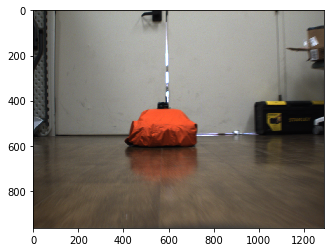

In [351]:
img = cv2.cvtColor(get_image(5,data),cv2.COLOR_BGR2RGB)
plt.imshow(img)

(416, 493)
(724, 600)


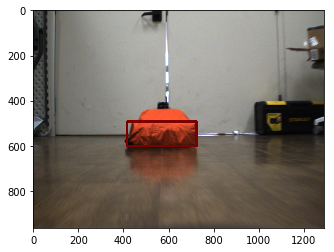

In [352]:
fin,x,y = frame_to_bounding_box(img,'rgb')
print(x)
print(y)
plt.imshow(img)

## Process the Data

Process all of the images, define data moment function. This returns 2 torch Variables, one for the input data, and on for the ground truth associated with it.


In [353]:
imgs = data[:,3]
img_bbox = []
for img in imgs:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = frame_to_bounding_box(img, 'rgb')
    img_bbox.append((img[1], img[2]))
img_bbox = np.array(img_bbox)
shp = img_bbox.shape
img_bbox = img_bbox.reshape((shp[0],shp[1]*shp[2]))
print(img_bbox.shape)

(367, 4)


In [354]:
def get_training(data,bbox,i):
    gtruth = np.array(get_hedge(i,data))
    lidar = np.hstack(get_lidar(i,data))
    for j in range(lidar.shape[0]):
        if lidar[j] == float('inf'):
            lidar[j] = 0
        elif lidar[j] == -float('inf'):
            lidar[j] = 0
            
    
    gtruth = gtruth.astype(float)
    boxi = bbox[i,:]
    training_moment = torch.from_numpy(np.hstack((boxi,lidar))).float()
    training_var = Variable(training_moment,requires_grad=True)
    gtruth = torch.from_numpy(gtruth).float()
    gtruth_var = Variable(gtruth,requires_grad=False)
    return training_var,gtruth_var
        

Show some of the dimensions of the data:

In [355]:
lid = get_lidar(2,data)
stacked = np.hstack(lid)
lidx = np.array(lid[0])
print(stacked.shape,lidx.shape)

(720,) (360,)


In [356]:
training_var,gtruth_var = get_training(data,img_bbox,1)
#print(gtruth_var,training_var)
inShp = training_var.shape
outShp = gtruth_var.shape
print(inShp,outShp)

torch.Size([724]) torch.Size([2])


## Defining the Neural Network

Create network Class, instantiate an instance of the network (random weights), define the loss function, and feed some random vectors through to make sure it works

In [357]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        #self.conv1 = nn.Conv2
        self.fc1 = nn.Linear(724, 40,bias=False)
        self.fc2 = nn.Linear(40,2,bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    

In [358]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=724, out_features=40, bias=False)
  (fc2): Linear(in_features=40, out_features=2, bias=True)
)


In [359]:
loss_fn = nn.MSELoss()
inputs = Variable(torch.randn(inShp))
out = net.forward(inputs)
params = list(net.parameters())
loss = loss_fn(out,gtruth_var)
print(len(params))
print(out)
print(loss)


3
Variable containing:
-0.1181
-0.0825
[torch.FloatTensor of size 2]

Variable containing:
 2.2982
[torch.FloatTensor of size 1]



## Training the Network

Zero out the gradiants to begin with. Define the Optimizer (use SGD). Define the number of epochs (number of times we loop over the dataset), define how many samples will be set aside for validation. Run the training session.

In [360]:
net.zero_grad()
out.backward(torch.randn(2))

In [361]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
n_epochs = 500
samples = data.shape[0]
validate_n = 27
n_max = samples - validate_n
losses = []


In [362]:
for epoch in tqdm.tqdm(range(n_epochs)):# loop over the dataset multiple times
    #print('epoch',epoch)
    for i in range(n_max):
        # get the inputs
        training_var,gtruth_var = get_training(data,img_bbox,i)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(training_var)
        loss = loss_fn(outputs, gtruth_var)
        #if loss.data.numpy() != float('inf'):
        loss.backward()
        optimizer.step()
        losses.append(loss.data.numpy())
        #print(outputs,gtruth_var)
        

print('Finished Training')


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


Finished Training


## Results From Training

First check for a random sample that the output makes sense. Eg, the output is not NaN or +/- inf

In [378]:
t,l = get_training(data,img_bbox,10)

outputs = net.forward(t)
loss = loss_fn(outputs,l)
print(outputs,loss)

Variable containing:
-1.5746
 0.0988
[torch.FloatTensor of size 2]
 Variable containing:
 0.2287
[torch.FloatTensor of size 1]



Plot the error of every single training iteration:

(170000, 1)
Average loss per iteration, final epoch:  0.32451048


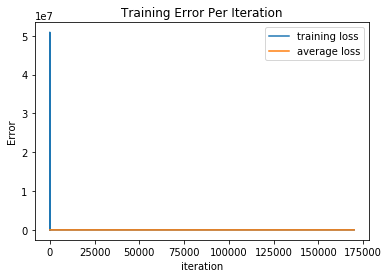

In [364]:
##Plot losses
losses = np.array(losses)
print(losses.shape)
iterations= np.linspace(1,n_max*n_epochs,n_max*n_epochs)
avg_loss = np.average(losses[-n_max:])
print('Average loss per iteration, final epoch: ',avg_loss)
plt.plot(iterations,losses,iterations,avg_loss*np.ones(iterations.shape))
plt.title('Training Error Per Iteration')
plt.ylabel('Error')
plt.xlabel('iteration')
plt.legend(('training loss','average loss'))



## Validate over unseen datapoints

Plot the error over all the validation points.

Average loss per iteration:  0.1098461


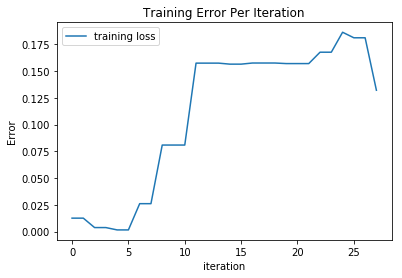

In [365]:
####validation
validation_loss = []
for i in range(n_max-1,samples):
    
    training_var,gtruth_var = get_training(data,img_bbox,i)
    
    outputs = net(training_var)
    #print(gtruth_var,outputs)
    loss = loss_fn(outputs, gtruth_var)
    validation_loss.append(loss.data.numpy())

validation_loss = np.array(validation_loss)
avg_loss = np.average(validation_loss)
print('Average loss per iteration: ',avg_loss)
plt.plot(validation_loss)
plt.title('Training Error Per Iteration')
plt.ylabel('Error')
plt.xlabel('iteration')
plt.legend(('training loss','average loss'))
    
    
    
    
    

## Plot the result for some of the datapoints

In [366]:
## Plotting of result
results = []
for l in range(samples):
    
    training_var,gtruth_var = get_training(data,img_bbox,l)
    outputs = net(training_var)
    results.append(outputs.data.numpy())



[[-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 [-1.5746207   0.09882987]
 

 [-1.5746207   0.09882987]]


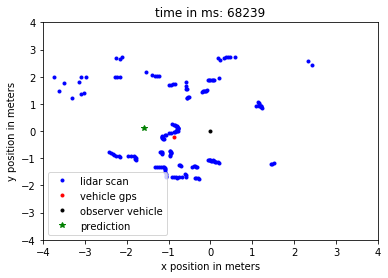

In [367]:
results = np.array(results)
print(results[:,:])
#plt.plot(results[-10:,0],results[-10:,1],'*b')
fig = plt.figure()
i = 300
#for i in range(data.shape[0]):
lidar = get_lidar(i,data)
hedge = get_hedge(i,data)
plt.cla()
plt.axis((-4,4,-4,4))
plt.plot(lidar[0],lidar[1],'.b',hedge[0],hedge[1],'.r',0,0,'k.',results[i,0],results[i,1],'*g')
plt.title('time in ms: ' + str(get_timestamp(i,data)))
plt.xlabel('x position in meters')
plt.ylabel('y position in meters')
plt.legend(('lidar scan','vehicle gps','observer vehicle','prediction'),loc=3)
    
   